# Script to demonstrate loading geodata from OSM and working with them

In [1]:
from shapely.geometry import Polygon,LineString

from shapely.ops import linemerge, unary_union, polygonize

import datetime
import numpy as np
import pysal
import geopandas as gpd
from matplotlib import pyplot as plt
from shapely.geometry import Point
import requests
import random
import overpy

import pandas as pd

<b> TARGET: </b> count the number of stores in the districts of the City and visualize the density on the map

### Loading districts

In [2]:
overpass_query = \
"""[out:json]
;
area["name:en"="Berlin"];
(
  relation
    ["boundary"="administrative"]
    ["admin_level"="9"]
    (area);
);
(
  ._;
  >;
);
out geom;
 """

### Using overpy library

In [3]:
api = overpy.Overpass()

city_borders = api.query(overpass_query)

In [4]:
type(city_borders.ways)

list

In [5]:
lss = []
for ii_w,way in enumerate(city_borders.ways):
    """loop on ribs"""
    ls_coords = []

    for node in way.nodes:
        ls_coords.append((node.lon,node.lat)) # 

    lss.append(LineString(ls_coords)) # Saving coordinates into line  -linestring


merged = linemerge([*lss]) # Connecting all lines
borders = unary_union(merged) # Converting linestrings to multistring
polygons = list(polygonize(borders))

In [6]:
gdf_zones_overpass= pd.Series(polygons, index=range(len(polygons))).to_frame()
gdf_zones_overpass.columns=['geometry']

In [7]:
gdf_zones_overpass =gpd.GeoDataFrame(gdf_zones_overpass, crs='epsg:4326', geometry='geometry')

<AxesSubplot:>

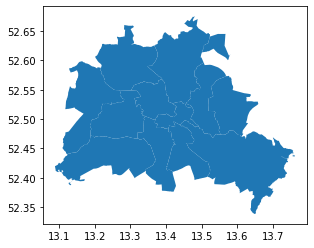

In [8]:
gdf_zones_overpass.plot()

### Using standart HTTP requests library

In [9]:
overpass_url = "http://overpass-api.de/api/interpreter"
response = requests.get(overpass_url, params={'data': overpass_query})
response.json()

{'version': 0.6,
 'generator': 'Overpass API 0.7.58.5 b0c4acbb',
 'osm3s': {'timestamp_osm_base': '2022-08-10T17:01:24Z',
  'timestamp_areas_base': '2022-07-20T11:06:24Z',
  'copyright': 'The data included in this document is from www.openstreetmap.org. The data is made available under ODbL.'},
 'elements': [{'type': 'node',
   'id': 21509149,
   'lat': 52.442978,
   'lon': 13.7569427},
  {'type': 'node', 'id': 26753043, 'lat': 52.5404013, 'lon': 13.4041908},
  {'type': 'node', 'id': 26753083, 'lat': 52.5323485, 'lon': 13.4064243},
  {'type': 'node', 'id': 26753581, 'lat': 52.5361014, 'lon': 13.4067482},
  {'type': 'node', 'id': 27199831, 'lat': 52.5675428, 'lon': 13.3844451},
  {'type': 'node', 'id': 27199834, 'lat': 52.5664477, 'lon': 13.3814821},
  {'type': 'node', 'id': 29215037, 'lat': 52.5082102, 'lon': 13.4052837},
  {'type': 'node', 'id': 29276220, 'lat': 52.5073345, 'lon': 13.4283665},
  {'type': 'node',
   'id': 29336704,
   'lat': 52.515747,
   'lon': 13.3096834,
   'tags': 

In [10]:
set([i['type'] for i in response.json()['elements']])

{'node', 'relation', 'way'}

In [11]:
dict_response = response.json()

In [12]:
dict_response['elements'][1984] #lets see somerandom element

{'type': 'node', 'id': 324083544, 'lat': 52.6601721, 'lon': 13.2861534}

In [13]:
lss = []
for way in dict_response['elements']:
    
    if way['type']=='way':
        line = LineString([(node['lon'],node['lat']) for node in way['geometry']]) # 
        lss.append(line) # Saving coordinates into line  -linestring


merged = linemerge([*lss]) # Connecting all lines
borders = unary_union(merged)# Converting linestrings to multistring

polygons = list(polygonize(borders))

In [14]:
gdf_zones_url= pd.Series(polygons, index=range(len(polygons))).to_frame()
gdf_zones_url.columns=['geometry']

In [15]:
gdf_zones_url =gpd.GeoDataFrame(gdf_zones_url, crs='epsg:4326', geometry='geometry')

<AxesSubplot:>

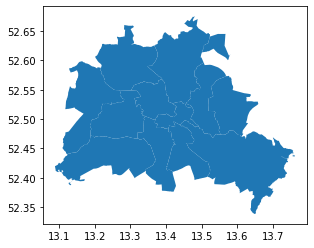

In [16]:
gdf_zones_url.plot()

### Loading geojson from overpass turbo with geopandas

 Links overpass turbo - https://overpass-turbo.eu/

 Data QUERY:
 
```ruby
[out:json];
 area["name:en"="Berlin"];
 (
     rel["boundary"="administrative"]["admin_level"="9"](area);
 );
/*added by auto repair*/
 (._;>;);
/*end of auto repair*/
out;
```

In [17]:
df_city_borders = gpd.read_file('berlin_borders.geojson')

In [18]:
df_city_borders.head()

,id,@id,TMC:cid_58:tabcd_1:Class,TMC:cid_58:tabcd_1:LCLversion,TMC:cid_58:tabcd_1:LocationCode,access,addr:city,addr:country,addr:housename,addr:housenumber,...,toilets,traffic_sign,type,waterway,website,wheelchair,wikidata,wikipedia,@relations,geometry
0,relation/16334,relation/16334,Area,9.00,4942,None,None,None,None,None,...,None,None,boundary,None,http://www.berlin.de/ba-reinickendorf/,None,Q158876,de:Bezirk Reinickendorf,None,"POLYGON ((13.21740 52.58748, 13.21644 52.58571..."
1,relation/16343,relation/16343,None,None,None,None,None,None,None,None,...,None,None,boundary,None,http://www.berlin.de/ba-spandau/,None,Q158083,de:Bezirk Spandau,None,"POLYGON ((13.15724 52.50162, 13.15722 52.50162..."
2,relation/16347,relation/16347,Area,9.00,4885,None,None,None,None,None,...,None,None,boundary,None,None,None,Q163966,de:Bezirk Mitte,None,"POLYGON ((13.39929 52.54894, 13.39929 52.54895..."
3,relation/55734,relation/55734,Area,9.00,32815,None,None,None,None,None,...,None,None,boundary,None,http://www.berlin.de/ba-steglitz-zehlendorf/,None,Q158064,de:Bezirk Steglitz-Zehlendorf,None,"POLYGON ((13.34570 52.41524, 13.34603 52.41553..."
4,relation/55754,relation/55754,Area,9.00,32817,None,None,None,None,None,...,None,None,boundary,None,http://www.berlin.de/ba-treptow-koepenick/,None,Q158089,de:Bezirk Treptow-Köpenick,None,"POLYGON ((13.71002 52.39628, 13.71018 52.39619..."


In [19]:
type(df_city_borders)

geopandas.geodataframe.GeoDataFrame

In [20]:
df_city_borders.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

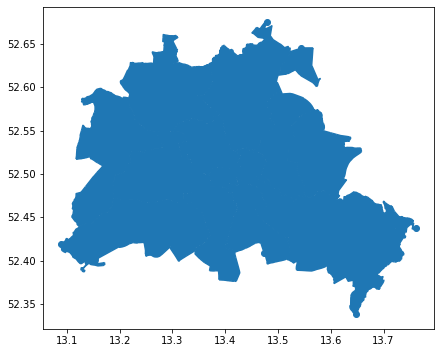

In [21]:
df_city_borders.plot(figsize=(7,10))

In [22]:
df_city_borders.geometry.head()

0    POLYGON ((13.21740 52.58748, 13.21644 52.58571...
1    POLYGON ((13.15724 52.50162, 13.15722 52.50162...
2    POLYGON ((13.39929 52.54894, 13.39929 52.54895...
3    POLYGON ((13.34570 52.41524, 13.34603 52.41553...
4    POLYGON ((13.71002 52.39628, 13.71018 52.39619...
Name: geometry, dtype: geometry

### Calculating districts area

In [23]:
df_city_borders.area

/var/folders/b7/qjb6gwz957n_8d871l0pzdm00000gn/T/ipykernel_8374/3183481316.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_city_borders.area


0      0.011848
1      0.012165
2      0.005216
3      0.013554
4      0.022160
         ...   
539    0.000000
540    0.000000
541    0.000000
542    0.000000
543    0.000000
Length: 544, dtype: float64

### Re-project geometries to a projected CRS UTM (Transverse Mercator) see https://epsg.io/ for epsg number

In [24]:
df_city_borders_mercator  = df_city_borders.to_crs('epsg:32633')# ATTENTION: epsg:<num> is specific to your location see https://epsg.io/

In [25]:
df_city_borders_mercator.geometry.head()

0    POLYGON ((379236.712 5827874.852, 379166.892 5...
1    POLYGON ((374917.759 5818428.414, 374916.292 5...
2    POLYGON ((391463.336 5823299.145, 391463.099 5...
3    POLYGON ((387489.258 5808511.727, 387512.070 5...
4    POLYGON ((412227.888 5805898.116, 412238.699 5...
Name: geometry, dtype: geometry

In [26]:
df_city_borders_mercator.crs

<Derived Projected CRS: EPSG:32633>
Name: WGS 84 / UTM zone 33N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 12°E and 18°E, northern hemisphere between equator and 84°N, onshore and offshore. Austria. Bosnia and Herzegovina. Cameroon. Central African Republic. Chad. Congo. Croatia. Czechia. Democratic Republic of the Congo (Zaire). Gabon. Germany. Hungary. Italy. Libya. Malta. Niger. Nigeria. Norway. Poland. San Marino. Slovakia. Slovenia. Svalbard. Sweden. Vatican City State.
- bounds: (12.0, 0.0, 18.0, 84.0)
Coordinate Operation:
- name: UTM zone 33N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [27]:
df_city_borders['area']=df_city_borders_mercator.area

In [28]:
df_city_borders['area'].value_counts() # There are points, district borders turns nodes, we need to remove them.

0.000000e+00    530
8.929648e+07      1
9.183423e+07      1
3.936867e+07      1
1.025267e+08      1
1.676258e+08      1
2.035939e+07      1
5.303804e+07      1
4.492633e+07      1
6.179157e+07      1
1.031671e+08      1
6.464723e+07      1
5.210910e+07      1
1.287973e+07      1
1.605912e+03      1
Name: area, dtype: int64

In [29]:
df_city_borders = df_city_borders[df_city_borders['area']>0]

<AxesSubplot:>

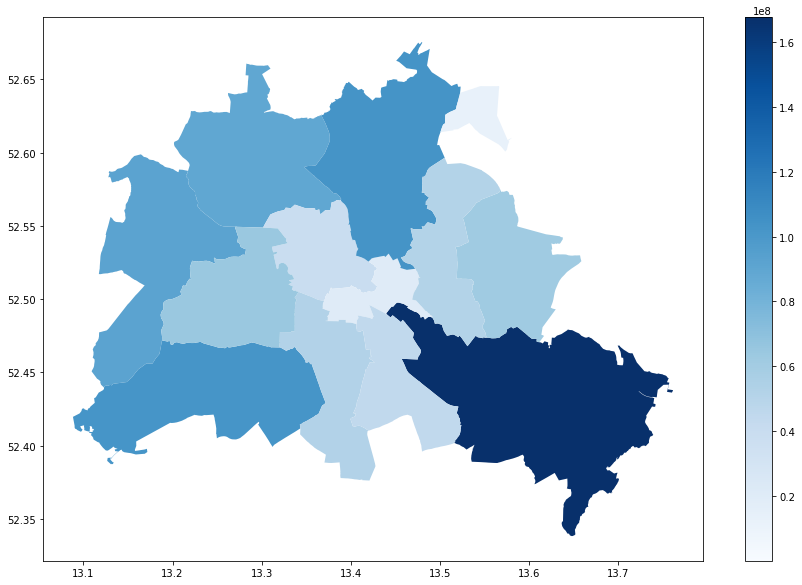

In [30]:
df_city_borders.plot(figsize=(15,10),column='area', cmap='Blues' ,legend=True) # Districts heatmap by area

## Loading list of supermarkets

In [31]:
query_sups="""area["name:en"="Berlin"];
        (
            node['shop'='supermarket'](area);
        );
        out;
        """
result1 = api.query(query_sups)

In [32]:
gdf_stores = gpd.GeoDataFrame([ Point(x.lon, x.lat) for x in result1.nodes])
gdf_stores.columns=['geometry']

In [33]:
gdf_stores.head()

,geometry
0,POINT (13.40737 52.50982)
1,POINT (13.31248 52.57168)
2,POINT (13.31693 52.56640)
3,POINT (13.32114 52.57049)
4,POINT (13.32288 52.49140)


##### Setting progection

<AxesSubplot:>

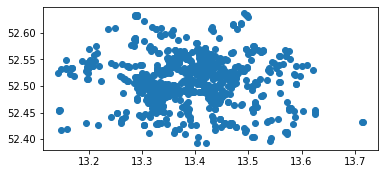

In [34]:
gdf_stores.crs
gdf_stores.plot()

In [35]:
gdf_stores = gdf_stores.set_crs('epsg:4326')

<AxesSubplot:>

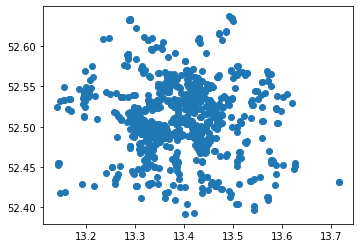

In [36]:
gdf_stores.crs
gdf_stores.plot()

### Connecting districts to supermarket stats

In [37]:
gdf_city_regions_shops = gpd.sjoin(df_city_borders, gdf_stores, predicate='contains', how='left')

In [38]:
gdf_city_regions_shops.head()

,id,@id,TMC:cid_58:tabcd_1:Class,TMC:cid_58:tabcd_1:LCLversion,TMC:cid_58:tabcd_1:LocationCode,access,addr:city,addr:country,addr:housename,addr:housenumber,...,type,waterway,website,wheelchair,wikidata,wikipedia,@relations,geometry,area,index_right
0,relation/16334,relation/16334,Area,9.00,4942,None,None,None,None,None,...,boundary,None,http://www.berlin.de/ba-reinickendorf/,None,Q158876,de:Bezirk Reinickendorf,None,"POLYGON ((13.21740 52.58748, 13.21644 52.58571...",8.929648e+07,56.0
0,relation/16334,relation/16334,Area,9.00,4942,None,None,None,None,None,...,boundary,None,http://www.berlin.de/ba-reinickendorf/,None,Q158876,de:Bezirk Reinickendorf,None,"POLYGON ((13.21740 52.58748, 13.21644 52.58571...",8.929648e+07,157.0
0,relation/16334,relation/16334,Area,9.00,4942,None,None,None,None,None,...,boundary,None,http://www.berlin.de/ba-reinickendorf/,None,Q158876,de:Bezirk Reinickendorf,None,"POLYGON ((13.21740 52.58748, 13.21644 52.58571...",8.929648e+07,325.0
0,relation/16334,relation/16334,Area,9.00,4942,None,None,None,None,None,...,boundary,None,http://www.berlin.de/ba-reinickendorf/,None,Q158876,de:Bezirk Reinickendorf,None,"POLYGON ((13.21740 52.58748, 13.21644 52.58571...",8.929648e+07,10.0
0,relation/16334,relation/16334,Area,9.00,4942,None,None,None,None,None,...,boundary,None,http://www.berlin.de/ba-reinickendorf/,None,Q158876,de:Bezirk Reinickendorf,None,"POLYGON ((13.21740 52.58748, 13.21644 52.58571...",8.929648e+07,593.0


In [39]:
gdf_city_regions = gdf_city_regions_shops[['name','area','id','geometry']].dissolve(by=['name','area'], aggfunc='count') # Group by districts and counting number of shops

In [40]:
gdf_city_regions

,,geometry,id
name,area,,
Charlottenburg-Wilmersdorf,6.464723e+07,"POLYGON ((13.33533 52.51504, 13.33538 52.51486...",117
Friedrichshain-Kreuzberg,2.035939e+07,"POLYGON ((13.47414 52.51894, 13.47547 52.51691...",90
Lichtenberg,5.210910e+07,"POLYGON ((13.46810 52.52349, 13.46760 52.52366...",44
Marzahn-Hellersdorf,6.179157e+07,"POLYGON ((13.54232 52.56615, 13.54240 52.56616...",30
Mitte,3.936867e+07,"POLYGON ((13.39935 52.54656, 13.39936 52.54654...",123
Neukölln,4.492633e+07,"POLYGON ((13.43194 52.41252, 13.43035 52.41225...",83
Pankow,1.031671e+08,"MULTIPOLYGON (((13.39685 52.55070, 13.39719 52...",104
Reinickendorf,8.929648e+07,"POLYGON ((13.21886 52.59237, 13.21812 52.59319...",42
Schwanebeck,1.287973e+07,"POLYGON ((13.50472 52.61964, 13.50461 52.61959...",1


In [41]:
gdf_city_regions.reset_index(inplace=True) #reseting index for better performance

In [42]:
# density per 1 km2
gdf_city_regions['density']=gdf_city_regions['id']/gdf_city_regions['area']/(10**(-6))

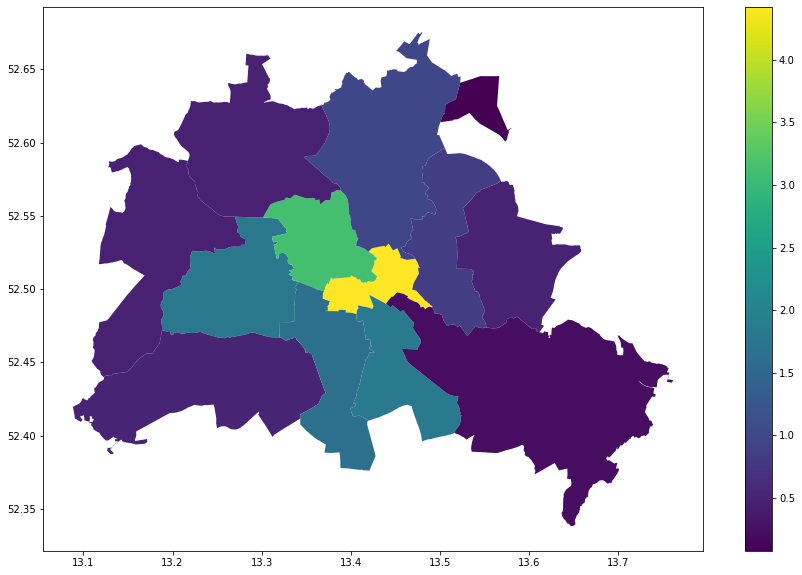

In [43]:
gdf_city_regions.plot(column='density', figsize=(15,10),legend=True);

In [44]:
gdf_city_regions.to_file('gdf_city_regions.geojson', driver='GeoJSON')

/Users/yurivlasov/Projects/miniforge3/envs/all_geodata_scripts/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
